**Installing Libraries**

In [1]:
!pip install pandas torch torchvision torch-geometric matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.7 MB/s eta 0:00:00


**Constructing Graph**

Mounted at /content/drive
                 Date       cfs     cfs.1     cfs.2     cfs.3     cfs.4  \
0 2023-10-01 00:10:00  0.029362  0.012352  0.017731  0.010798  0.030601   
1 2023-10-01 00:20:00  0.055978  0.012352  0.044930  0.010798  0.059008   
2 2023-10-01 00:30:00  0.095967  0.012352  0.086999  0.010798  0.105134   
3 2023-10-01 00:40:00  0.142564  0.012352  0.134896  0.010798  0.144840   
4 2023-10-01 00:50:00  0.178755  0.012352  0.166028  0.010798  0.171380   

      cfs.5     cfs.6     cfs.7     cfs.8  ...    cfs.13    cfs.14    cfs.15  \
0  0.022105  0.006998  0.010816  0.007112  ...  0.002225  0.025429  0.024921   
1  0.057283  0.006998  0.019690  0.007112  ...  0.002136  0.062740  0.064320   
2  0.098656  0.006998  0.025159  0.007112  ...  0.002134  0.097285  0.100896   
3  0.134688  0.006998  0.025570  0.007112  ...  0.002134  0.126184  0.136423   
4  0.152587  0.006998  0.025531  0.007112  ...  0.002134  0.132118  0.149922   

     cfs.16    cfs.17    cfs.18    cfs.19 

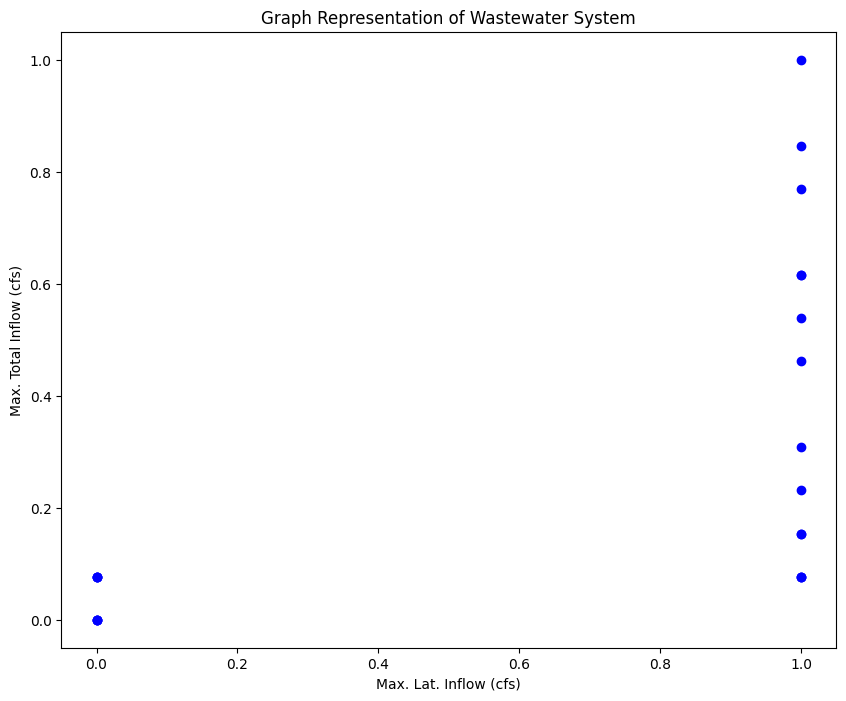

In [2]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from google.colab import drive
import warnings

warnings.filterwarnings('ignore')

drive.mount('/content/drive')

edge_df = pd.read_csv('/content/drive/My Drive/wateranolomy/WW01_edge.csv')
edge_df.columns = edge_df.columns.str.strip()

node_df = pd.read_csv('/content/drive/My Drive/wateranolomy/WW01_node.csv')
node_df.columns = node_df.columns.str.strip()

flow_df = pd.read_excel('/content/drive/My Drive/wateranolomy/Flow_rate.xlsx')
depth_df = pd.read_excel('/content/drive/My Drive/wateranolomy/WW01_v3.xlsx')

flow_df.columns = flow_df.columns.str.strip()
depth_df.columns = depth_df.columns.str.strip()

flow_df.rename(columns={'M/d/yyyy': 'Date'}, inplace=True)
depth_df.rename(columns={'M/d/yyyy': 'Date'}, inplace=True)

flow_df['Date'] = pd.to_datetime(flow_df['Date'])
depth_df['Date'] = pd.to_datetime(depth_df['Date'])

merged_df = pd.merge(flow_df, depth_df, on='Date', how='left')

flow_columns = [col for col in flow_df.columns if 'cfs' in col]
depth_columns = [col for col in depth_df.columns if 'ft' in col]

flow_features = merged_df[['Date'] + flow_columns]
depth_features = merged_df[['Date'] + depth_columns]

print(flow_features.head())
print(depth_features.head())

flow_features[flow_columns] = flow_features[flow_columns].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

depth_features[depth_columns] = depth_features[depth_columns].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

edge_features = edge_df[['Inlet Node', 'Outlet Node', 'Length (ft)', 'Roughness', 'Slope (ft/ft)', 'Max. |Flow| (cfs)']].copy()

node_mapping = {node: idx for idx, node in enumerate(node_df['Node ID'].unique())}
edge_features['Inlet Node'] = edge_features['Inlet Node'].map(node_mapping)
edge_features['Outlet Node'] = edge_features['Outlet Node'].map(node_mapping)

missing_nodes = edge_features[edge_features[['Inlet Node', 'Outlet Node']].isnull().any(axis=1)]
if not missing_nodes.empty:
    print("Warning: Missing nodes detected!")
    print(missing_nodes)
    edge_features.dropna(subset=['Inlet Node', 'Outlet Node'], inplace=True)

edge_index = torch.tensor(edge_features[['Inlet Node', 'Outlet Node']].values.T, dtype=torch.long)

edge_attr = torch.tensor(edge_features[['Length (ft)', 'Roughness', 'Slope (ft/ft)', 'Max. |Flow| (cfs)']].values, dtype=torch.float)

node_features = node_df[['Node ID', 'Max. Lat. Inflow (cfs)', 'Max. Total Inflow (cfs)',
                         'Max. Depth (ft)', 'Max. Unit Flow (cfs/ac)', 'GIS_LENGTH (m)']].copy()

node_features.dropna(subset=['Max. Lat. Inflow (cfs)', 'Max. Total Inflow (cfs)',
                             'Max. Depth (ft)', 'Max. Unit Flow (cfs/ac)', 'GIS_LENGTH (m)'], inplace=True)

columns_to_normalize = ['Max. Lat. Inflow (cfs)', 'Max. Total Inflow (cfs)',
                        'Max. Depth (ft)', 'Max. Unit Flow (cfs/ac)', 'GIS_LENGTH (m)']
node_features[columns_to_normalize] = node_features[columns_to_normalize].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

node_features_tensor = torch.tensor(
    node_features[['Max. Lat. Inflow (cfs)', 'Max. Total Inflow (cfs)',
                   'Max. Depth (ft)', 'Max. Unit Flow (cfs/ac)', 'GIS_LENGTH (m)']].values,
    dtype=torch.float
)

data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr)

print(data)

torch.save(data, 'graph_data.pt')

x_coords = node_features['Max. Lat. Inflow (cfs)']
y_coords = node_features['Max. Total Inflow (cfs)']

plt.figure(figsize=(10, 8))
plt.title('Graph Representation of Wastewater System')

plt.scatter(x_coords, y_coords, c='blue', label='Nodes')

for i in range(edge_index.shape[1]):
    x1 = x_coords.iloc[edge_index[0, i]]
    y1 = y_coords.iloc[edge_index[0, i]]
    x2 = x_coords.iloc[edge_index[1, i]]
    y2 = y_coords.iloc[edge_index[1, i]]

    plt.plot([x1, x2], [y1, y2], c='red', alpha=0.5)

plt.xlabel('Max. Lat. Inflow (cfs)')
plt.ylabel('Max. Total Inflow (cfs)')

plt.show()
warnings.filterwarnings('ignore', category=UserWarning, message=".*SettingWithCopyWarning.*")


**Training**

Epoch [0/100], Training Loss: 0.00230130, Validation Loss: 0.00000409
Epoch [10/100], Training Loss: 0.00049294, Validation Loss: 0.00149479
Epoch [20/100], Training Loss: 0.00011853, Validation Loss: 0.00000595
Epoch [30/100], Training Loss: 0.00001955, Validation Loss: 0.00000584
Epoch [40/100], Training Loss: 0.00001239, Validation Loss: 0.00005389
Epoch [50/100], Training Loss: 0.00001065, Validation Loss: 0.00001609
Epoch [60/100], Training Loss: 0.00000727, Validation Loss: 0.00000652
Epoch [70/100], Training Loss: 0.00000598, Validation Loss: 0.00000006
Epoch [80/100], Training Loss: 0.00000547, Validation Loss: 0.00000005
Epoch [90/100], Training Loss: 0.00000485, Validation Loss: 0.00000044
Epoch [0/100], Loss: 0.00709569
Epoch [10/100], Loss: 0.00301603
Epoch [20/100], Loss: 0.00214421
Epoch [30/100], Loss: 0.00181275
Epoch [40/100], Loss: 0.00159496
Epoch [50/100], Loss: 0.00141883
Epoch [60/100], Loss: 0.00126914
Epoch [70/100], Loss: 0.00114029
Epoch [80/100], Loss: 0.0010

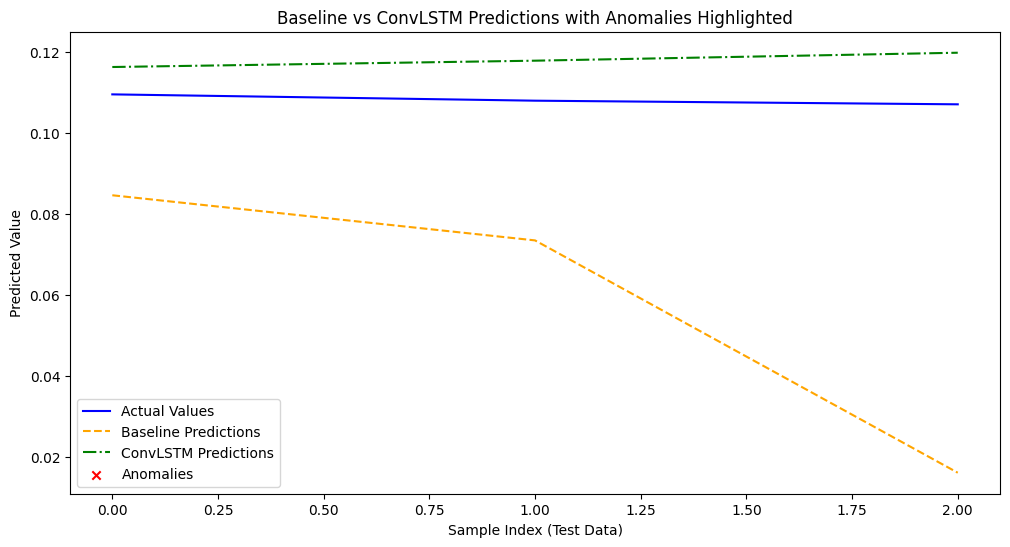

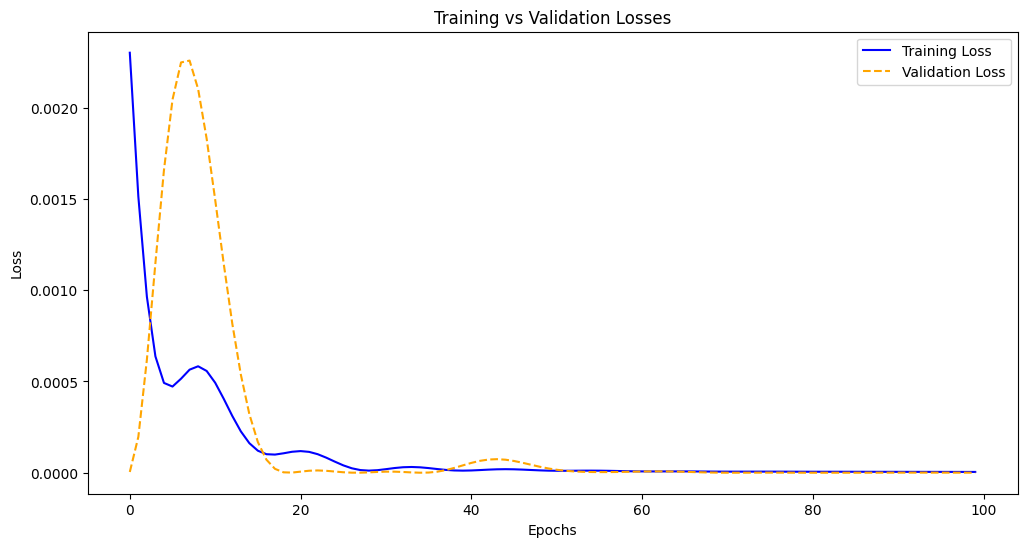

In [3]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class ConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(ConvLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def train_model_with_validation(model, train_data, train_labels, val_data, val_labels, epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(train_data)
        loss = criterion(predictions, train_labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_predictions = model(val_data)
            val_loss = criterion(val_predictions, val_labels)
            val_losses.append(val_loss.item())
        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{epochs}], Training Loss: {loss.item():.8f}, Validation Loss: {val_loss.item():.8f}')

    return train_losses, val_losses

node_df = pd.read_csv('/content/drive/MyDrive/wateranolomy/WW01_node.csv')
flow_depth_merged = pd.read_excel('/content/drive/MyDrive/wateranolomy/WW01_v3.xlsx')

columns_to_use = ['Max. Lat. Inflow (cfs)', 'Max. Total Inflow (cfs)', 'Max. Depth (ft)',
                  'Max. Unit Flow (cfs/ac)', 'GIS_LENGTH (m)']
node_features = node_df[columns_to_use]
node_features = (node_features - node_features.min()) / (node_features.max() - node_features.min())

target_column = 'ft'
y = flow_depth_merged[target_column].values

sequence_length = 10
num_features = len(columns_to_use)

X_train = []
y_train = []

for i in range(len(node_features) - sequence_length):
    X_train.append(node_features.iloc[i:i + sequence_length].values)
    y_train.append(y[i + sequence_length])

X_train = np.array(X_train, dtype=np.float32)

if np.isnan(X_train).any() or np.isnan(y_train).any():
    print('Warning: NaN values found in the dataset.')

X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

n_samples = len(X_train)
train_size = int(n_samples * 0.7)
val_size = int(n_samples * 0.1)
test_size = n_samples - train_size - val_size

X_train_data = X_train[:train_size]
X_val_data = X_train[train_size:train_size+val_size]
X_test_data = X_train[train_size+val_size:]

y_train_data = y_train[:train_size]
y_val_data = y_train[train_size:train_size+val_size]
y_test_data = y_train[train_size+val_size:]

X_train_tensor = torch.tensor(X_train_data, dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train_data).reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_data, dtype=torch.float32)
y_val_tensor = torch.tensor(np.array(y_val_data).reshape(-1, 1), dtype=torch.float32)

conv_lstm_model = ConvLSTM(input_size=num_features, hidden_size=32, output_size=1)
train_losses, val_losses = train_model_with_validation(conv_lstm_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

class LinearRegressionTorch(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

X_train_flat = X_train_data.reshape(len(X_train_data), -1)
X_test_flat = X_test_data.reshape(len(X_test_data), -1)

X_train_flat_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
y_train_flat_tensor = torch.tensor(np.array(y_train_data).reshape(-1, 1), dtype=torch.float32)
X_test_flat_tensor = torch.tensor(X_test_flat, dtype=torch.float32)

torch_linear_model = LinearRegressionTorch(input_dim=X_train_flat.shape[1], output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(torch_linear_model.parameters(), lr=0.01)

for epoch in range(100):
    torch_linear_model.train()
    optimizer.zero_grad()
    outputs = torch_linear_model(X_train_flat_tensor)
    loss = criterion(outputs, y_train_flat_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/100], Loss: {loss.item():.8f}')

with torch.no_grad():
    baseline_predictions = torch_linear_model(X_test_flat_tensor).numpy()

conv_lstm_predictions = conv_lstm_model(torch.tensor(X_test_data, dtype=torch.float32)).detach().numpy()
baseline_mse = ((np.array(y_test_data).reshape(-1) - baseline_predictions.reshape(-1)) ** 2).mean()
conv_lstm_mse = ((np.array(y_test_data).reshape(-1) - conv_lstm_predictions.reshape(-1)) ** 2).mean()
baseline_accuracy = 1 - (np.abs(y_test_data - baseline_predictions) / y_test_data).mean()
conv_lstm_accuracy = 1 - (np.abs(y_test_data - conv_lstm_predictions.flatten()) / y_test_data).mean()
print(f'Baseline MSE: {baseline_mse:.8f}')
print(f'Baseline Accuracy: {baseline_accuracy:.2%}')
print(f'ConvLSTM MSE: {conv_lstm_mse:.8f}')
print(f'ConvLSTM Accuracy: {conv_lstm_accuracy:.2%}')

error = np.abs(np.array(y_test_data) - conv_lstm_predictions.reshape(-1))
mean_error = np.mean(error)
std_error = np.std(error)
z_scores = (error - mean_error) / std_error
threshold = 3
anomalies = z_scores > threshold
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies detected: {num_anomalies}")
anomaly_indices = np.where(anomalies)[0]
print(f"Indices of anomalies: {anomaly_indices}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_data, label='Actual Values', color='blue', linewidth=1.5)
plt.plot(baseline_predictions, label='Baseline Predictions', linestyle='--', color='orange', linewidth=1.5)
plt.plot(conv_lstm_predictions, label='ConvLSTM Predictions', linestyle='-.', color='green', linewidth=1.5)
plt.scatter(anomaly_indices, y_test_data[anomaly_indices], color='red', label='Anomalies', marker='x')
plt.xlabel('Sample Index (Test Data)')
plt.ylabel('Predicted Value')
plt.title('Baseline vs ConvLSTM Predictions with Anomalies Highlighted')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=1.5)
plt.plot(val_losses, label='Validation Loss', linestyle='--', color='orange', linewidth=1.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Losses')
plt.legend(loc='best')
plt.show()
